## Assignment 1 - Machine Learning Project
### Project 1: Classify Images of Colon Cancer
##### Group No. 3: Sheikh Abdul Munim (s4076159), Liya Benoy (s4027344)

In [1]:
#importing required libraries
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
import numpy as np
import tensorflow as tf
import random
import os

seed = 42  # You can choose any number

# Set seed for built-in Python
random.seed(seed)

# Set seed for NumPy
np.random.seed(seed)

# Set seed for TensorFlow
tf.random.set_seed(seed)

# Optional: for full reproducibility (slower but stricter)
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'  # This is optional and may not be necessary for all TensorFlow versions

In [4]:
#importing the data labels (main+extra)
labels_main = pd.read_csv('Image_classification_data\data_labels_mainData.csv')
labels_extra = pd.read_csv('Image_classification_data\data_labels_extraData.csv')
print("labels_main columns:\n", labels_main.head())
print("\nlabels_extra columns:\n", labels_extra.head())

labels_main columns:
    InstanceID  patientID  ImageName cellTypeName  cellType  isCancerous
0       22405          1  22405.png   fibroblast         0            0
1       22406          1  22406.png   fibroblast         0            0
2       22407          1  22407.png   fibroblast         0            0
3       22408          1  22408.png   fibroblast         0            0
4       22409          1  22409.png   fibroblast         0            0

labels_extra columns:
    InstanceID  patientID  ImageName  isCancerous
0       12681         61  12681.png            0
1       12682         61  12682.png            0
2       12683         61  12683.png            0
3       12684         61  12684.png            0
4       12685         61  12685.png            0


In [25]:
#checking the data types
print("\nlabels_main dtypes:\n", labels_main.dtypes)
print("\nlabels_extra dtypes:\n", labels_extra.dtypes)


labels_main dtypes:
 InstanceID       int64
patientID        int64
ImageName       object
cellTypeName    object
cellType         int64
isCancerous      int64
Image           object
dtype: object

labels_extra dtypes:
 InstanceID      int64
patientID       int64
ImageName      object
isCancerous     int64
dtype: object


In [6]:
#navigating to folder containing colon cell histopathology images
image_folder = 'Image_classification_data\patch_images'
images = os.listdir(image_folder)
print(f"Total Numer of Images: {len(images)}")

Total Numer of Images: 20280


In [7]:
#checking if there are extra images in images folder that are not given in data labels
images_set = set(images)
csv_images_set = set(labels_main['ImageName'].astype(str))  #no '.png' added
print("Images in labels_main but missing from patch_images folder:", csv_images_set - images_set)
print("Images in patch_images folder but missing from labels_main:", images_set - csv_images_set)
#use only images that are listed in the CSV file
images_filtered = [img for img in images if img in csv_images_set]

Images in labels_main but missing from patch_images folder: set()
Images in patch_images folder but missing from labels_main: {'12552.png', '6186.png', '2409.png', '19141.png', '21439.png', '2890.png', '7022.png', '11600.png', '14134.png', '21425.png', '6898.png', '7502.png', '5338.png', '17951.png', '5875.png', '20608.png', '21387.png', '13142.png', '14343.png', '14773.png', '15981.png', '7331.png', '16115.png', '2617.png', '2810.png', '16075.png', '21324.png', '1791.png', '21530.png', '9830.png', '15611.png', '21963.png', '1969.png', '12817.png', '7247.png', '5083.png', '9780.png', '1747.png', '14259.png', '12871.png', '20477.png', '17626.png', '2137.png', '2923.png', '20623.png', '17987.png', '21958.png', '14779.png', '5261.png', '11578.png', '5315.png', '20614.png', '14943.png', '15433.png', '12716.png', '17966.png', '5463.png', '11432.png', '2605.png', '16203.png', '16422.png', '20721.png', '2262.png', '2529.png', '5948.png', '5713.png', '11188.png', '13026.png', '14307.png', '104

In [8]:
#defining function to load images
def load_images(image_folder, image_list):
    """Returns a dictionary mapping image names to PIL image objects."""
    images = {}
    for img_name in image_list:
        img_path = os.path.join(image_folder, img_name)
        try:
            with Image.open(img_path) as img:
                images[img_name] = img.copy()  # Copy to keep it after closing
        except Exception as e:
            print(f"Error loading {img_name}: {e}")
    return images
#loading the images
image_objects = load_images(image_folder, labels_main['ImageName'])
#adding a new column 'Image' to labels_main
labels_main['Image'] = labels_main['ImageName'].map(image_objects)
labels_main.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous,Image
0,22405,1,22405.png,fibroblast,0,0,<PIL.Image.Image image mode=RGB size=27x27 at ...
1,22406,1,22406.png,fibroblast,0,0,<PIL.Image.Image image mode=RGB size=27x27 at ...
2,22407,1,22407.png,fibroblast,0,0,<PIL.Image.Image image mode=RGB size=27x27 at ...
3,22408,1,22408.png,fibroblast,0,0,<PIL.Image.Image image mode=RGB size=27x27 at ...
4,22409,1,22409.png,fibroblast,0,0,<PIL.Image.Image image mode=RGB size=27x27 at ...


In [9]:
#grouping by 'cellTypeName' and 'isCancerous', then counting the entries
cell_type_counts = labels_main.groupby(['cellTypeName', 'isCancerous']).size().unstack(fill_value=0)
#renamining the columns for clarity
cell_type_counts.columns = ['Non-Cancerous', 'Cancerous']
cell_type_counts

,Non-Cancerous,Cancerous
cellTypeName,,
epithelial,0,4079
fibroblast,1888,0
inflammatory,2543,0
others,1386,0


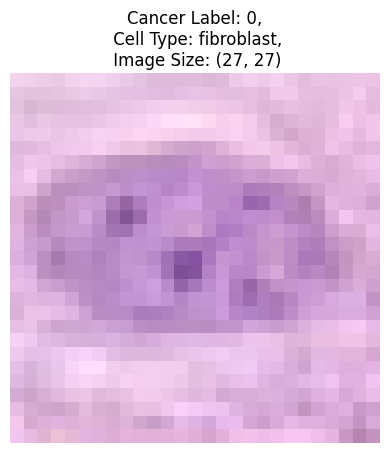

In [10]:
#fetching a single sample (e.g., for index 0)
index = 0
sample = labels_main.iloc[index]
#extracting the image, cancer label, and cell type
img = sample['Image']  # This must be a PIL Image object
cancer_label = sample['isCancerous']
cell_type = sample['cellTypeName']
#displaying the image
if img:
    plt.imshow(img)
    plt.title(f"Cancer Label: {cancer_label},\n Cell Type: {cell_type},\n Image Size: {img.size}")
    plt.axis('off')  #hiding axes
    plt.show()
else:
    print("Error: Image not found.")

### Exploratory Data Analysis (EDA)

In [11]:
#fetching the dimensions of the data
print("Dimensions of labels_main dataframe:", labels_main.shape)
print("\nDescriptive Statistics of labels_main dataframe:")
labels_main.describe()

Dimensions of labels_main dataframe: (9896, 7)

Descriptive Statistics of labels_main dataframe:


,InstanceID,patientID,cellType,isCancerous
count,9896.000000,9896.000000,9896.000000,9896.000000
mean,10193.880154,29.762025,1.501516,0.412187
std,6652.912660,17.486553,0.954867,0.492253
min,1.000000,1.000000,0.000000,0.000000
25%,4135.750000,14.000000,1.000000,0.000000
50%,9279.500000,26.000000,2.000000,0.000000
75%,16821.250000,47.000000,2.000000,1.000000
max,22444.000000,60.000000,3.000000,1.000000


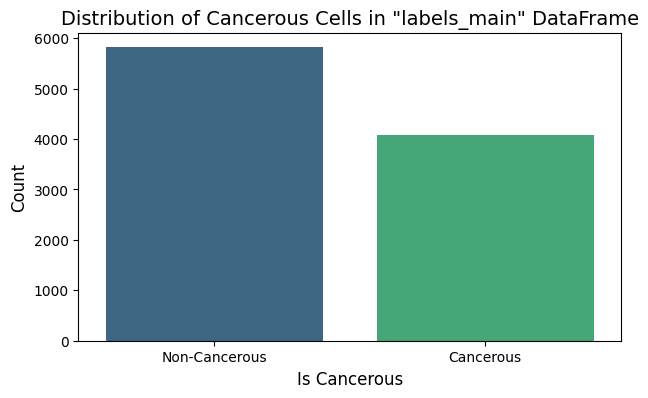

In [12]:
# Plotting the distribution of the 'inCancerous' label
plt.figure(figsize=(7, 4))
sns.countplot(data=labels_main, x='isCancerous', hue="isCancerous", palette='viridis', legend=False)
# Adding titles and labels
plt.title('Distribution of Cancerous Cells in "labels_main" DataFrame', fontsize=14)
plt.xlabel('Is Cancerous', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1], ['Non-Cancerous', 'Cancerous'])  # Adjust according to your label values
# Show the plot
plt.show()

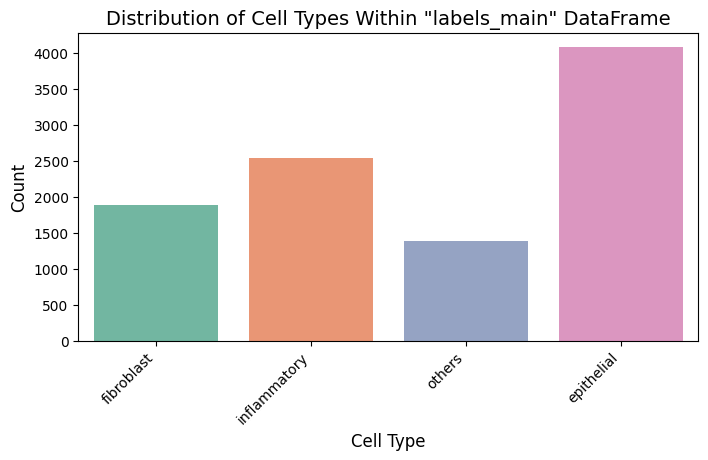

In [50]:
#plotting the distribution of the 'cellTypeName' label
plt.figure(figsize=(8, 4))
sns.countplot(data=labels_main, x='cellTypeName', hue='cellTypeName', palette='Set2', legend=False)
#adding titles and labels
plt.title('Distribution of Cell Types Within "labels_main" DataFrame', fontsize=14)
plt.xlabel('Cell Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate labels for better readability
plt.show()

In [13]:
#checking for missing values in the entire DataFrame
missing_values = labels_main.isnull().sum()
#displaying the columns with missing values
print("Missing values in each column:")
print(missing_values)
#optionally, you can filter columns with missing values only
missing_columns = missing_values[missing_values > 0]
print("\nColumns with missing values:")
print(missing_columns)

Missing values in each column:
InstanceID      0
patientID       0
ImageName       0
cellTypeName    0
cellType        0
isCancerous     0
Image           0
dtype: int64

Columns with missing values:
Series([], dtype: int64)


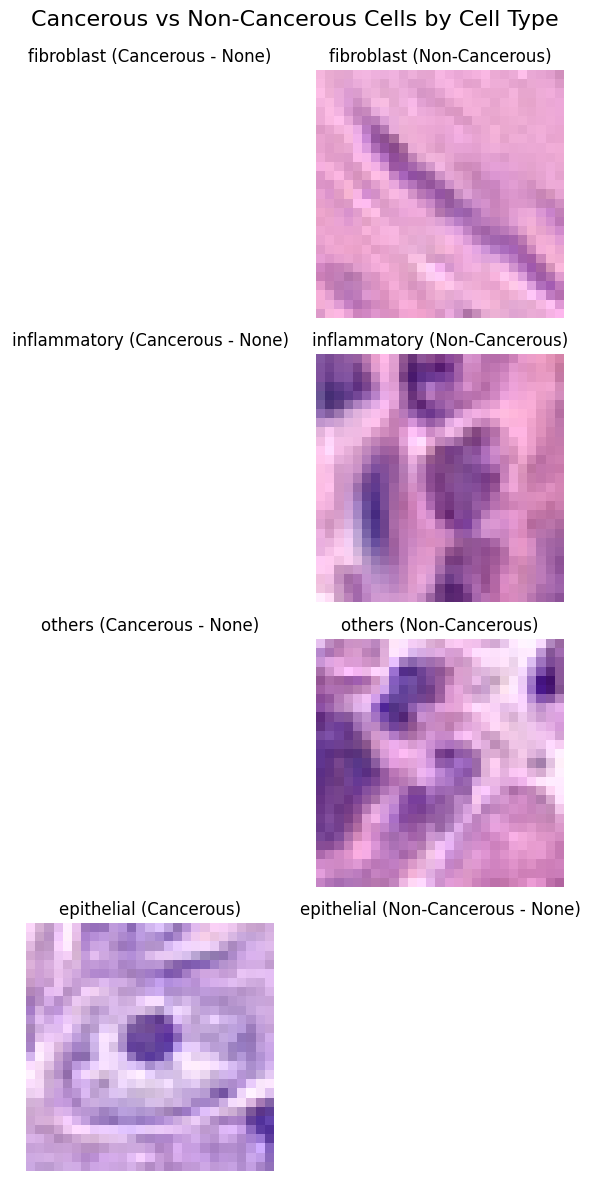

In [14]:
#getting unique cell types
cell_types = labels_main['cellTypeName'].dropna().unique()
#preparing the figure
fig, axes = plt.subplots(len(cell_types), 2, figsize=(6, 3 * len(cell_types)))
#ensure axes is 2D
if len(cell_types) == 1:
    axes = np.expand_dims(axes, axis=0)
#filtering cancerous and non-cancerous data 
for i, cell_type in enumerate(cell_types):
    cancerous_df = labels_main[(labels_main['cellTypeName'] == cell_type) & 
                               (labels_main['isCancerous'] == 1)]
    non_cancerous_df = labels_main[(labels_main['cellTypeName'] == cell_type) & 
                                   (labels_main['isCancerous'] == 0)]
    #plotting cancerous image for cell type
    if not cancerous_df.empty:
        img = cancerous_df.sample(1).iloc[0]['Image']
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f"{cell_type} (Cancerous)")
    else:
        axes[i, 0].set_title(f"{cell_type} (Cancerous - None)")
    axes[i, 0].axis('off')
    #plotting non-cancerous image for cell type
    if not non_cancerous_df.empty:
        img = non_cancerous_df.sample(1).iloc[0]['Image']
        axes[i, 1].imshow(img)
        axes[i, 1].set_title(f"{cell_type} (Non-Cancerous)")
    else:
        axes[i, 1].set_title(f"{cell_type} (Non-Cancerous - None)")
    axes[i, 1].axis('off')
#plotting comparison images
plt.suptitle('Cancerous vs Non-Cancerous Cells by Cell Type', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

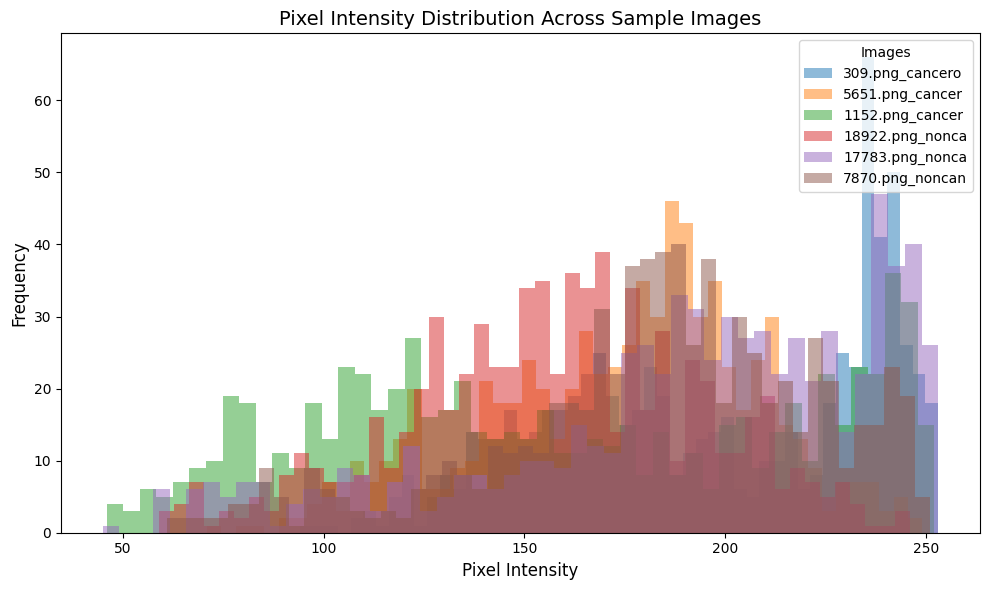

In [15]:
#filtering the main dataframe
cancerous_cells = labels_main[labels_main['isCancerous'] == 1]
non_cancerous_cells = labels_main[labels_main['isCancerous'] == 0]
#defining function to calculate pixel intensity distribution for grayscale images
def plot_pixel_intensity_distribution(images, title="Pixel Intensity Distribution"):
    plt.figure(figsize=(10, 6))
    for idx, (img_name, img) in enumerate(images.items()):
        if img is not None:
            img_gray = img.convert("L")  # Convert image to grayscale
            img_array = np.array(img_gray)
            plt.hist(img_array.flatten(), bins=50, alpha=0.5, label=img_name[:15])  # Truncate long names
    plt.title(title, fontsize=14)
    plt.xlabel('Pixel Intensity', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.legend(title="Images", loc='upper right')
    plt.tight_layout()
    plt.show()
#using a sample of 3 cancerous and 3 non-cancerous images
sample_cancerous_images = cancerous_cells.sample(3, random_state=42)
sample_non_cancerous_images = non_cancerous_cells.sample(3, random_state=42)
#combining the images in a dictionary
sample_images = {}
for idx, row in sample_cancerous_images.iterrows():
    sample_images[f"{row['ImageName']}_cancerous"] = row['Image']
for idx, row in sample_non_cancerous_images.iterrows():
    sample_images[f"{row['ImageName']}_noncancerous"] = row['Image']
#plotting the pixel intensity distribution of the 9 images
plot_pixel_intensity_distribution(sample_images, title="Pixel Intensity Distribution Across Sample Images")

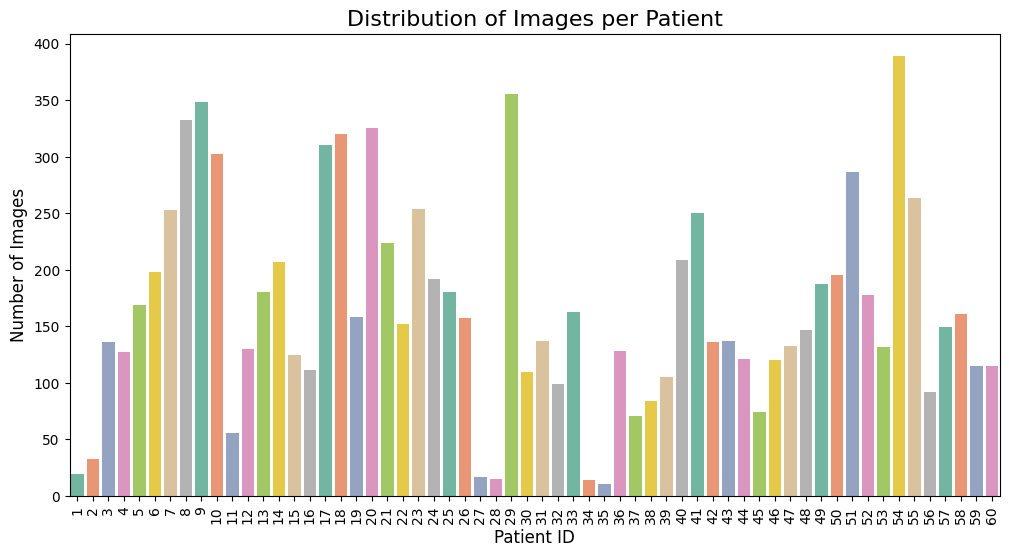

In [16]:
#grouping the data by PatientID and counting the number of images per patient
patient_distribution = labels_main['patientID'].value_counts()
#plotting the patient distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=patient_distribution.index, hue=patient_distribution.index, y=patient_distribution.values, palette="Set2", legend=False)
#adding title and labels
plt.title('Distribution of Images per Patient', fontsize=16)
plt.xlabel('Patient ID', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

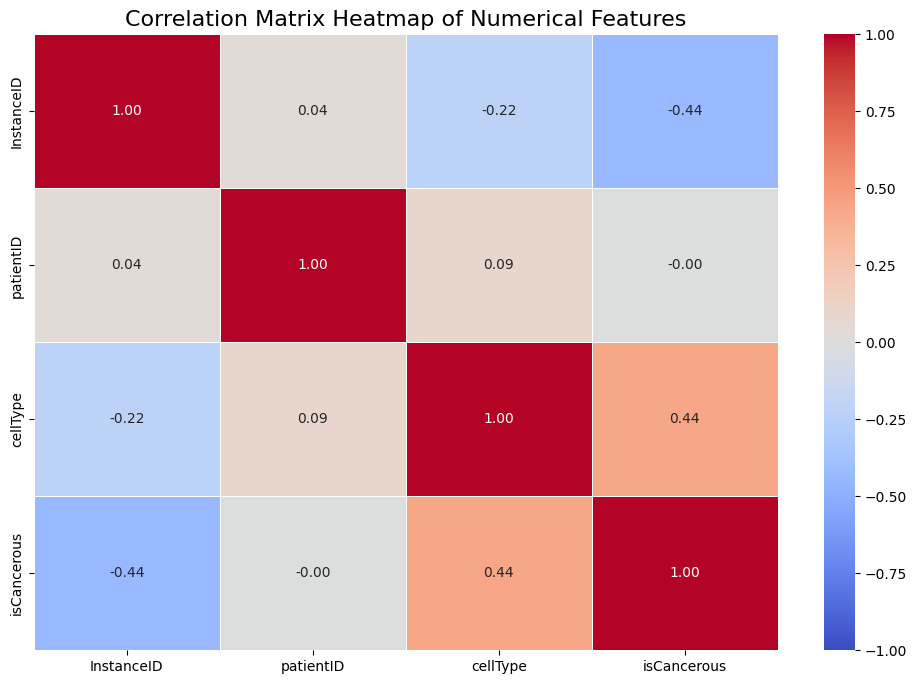

In [17]:
#select only numerical columns
numerical_features = labels_main.select_dtypes(include=['float64', 'int64'])
#calculate the correlation matrix
corr_matrix = numerical_features.corr()
#plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap of Numerical Features', fontsize=16)
plt.show()

In [18]:
#function to classify images as too bright or too dark based on average pixel intensity
def check_image_brightness(images, bright_threshold=200, dark_threshold=50):
    too_bright = []
    too_dark = []  
    for img_name, img in images.items():
        # Convert the image to grayscale
        img_gray = img.convert("L")
        img_array = np.array(img_gray)  # Convert image to numpy array
        #calculate the average pixel intensity
        avg_intensity = img_array.mean()
        #classify image as too bright or too dark
        if avg_intensity > bright_threshold:
            too_bright.append(img_name)
        elif avg_intensity < dark_threshold:
            too_dark.append(img_name)
    return too_bright, too_dark
#check the brightness of the images
too_bright_images, too_dark_images = check_image_brightness(image_objects)
#display the results
print("Too Bright Images:", too_bright_images)
print("Too Dark Images:", too_dark_images)

Too Bright Images: ['22408.png', '22409.png', '22423.png', '19036.png', '19043.png', '19045.png', '19049.png', '19050.png', '19062.png', '19066.png', '18945.png', '18653.png', '132.png', '133.png', '135.png', '153.png', '156.png', '158.png', '161.png', '162.png', '163.png', '164.png', '165.png', '167.png', '168.png', '172.png', '173.png', '175.png', '176.png', '177.png', '178.png', '179.png', '180.png', '181.png', '183.png', '184.png', '187.png', '190.png', '191.png', '192.png', '193.png', '194.png', '195.png', '196.png', '197.png', '198.png', '199.png', '200.png', '201.png', '203.png', '204.png', '205.png', '207.png', '212.png', '213.png', '215.png', '220.png', '221.png', '222.png', '223.png', '227.png', '228.png', '229.png', '230.png', '232.png', '233.png', '234.png', '235.png', '241.png', '242.png', '243.png', '253.png', '254.png', '256.png', '257.png', '260.png', '262.png', '264.png', '270.png', '271.png', '273.png', '274.png', '275.png', '4087.png', '4089.png', '4092.png', '4096.p

### Data Pre-processing

In [19]:

"""    
The following code loads the images, resizes them to 27x27 pixels, normalizes the pixel values, and prepares the labels for CNN training.
The code also combines the labels from the main and extra detasets, however if you do not want to use the extra dataset, you can comment out the lines that load and concate the extra dataset.
The code also handles exceptions while loading images and prints the final shapes of the image dataset and labels.

"""




import os
import numpy as np
import pandas as pd
from PIL import Image

# Lists to store the data
X_task1 = []
y_isCancerous = []

X_task2 = []
y_cellType = []

# Combine only the isCancerous labels for Task 1
labels_task1 = pd.concat([labels_main, labels_extra], ignore_index=True)

# Use only main labels for Task 2 (cellType)
labels_task2 = labels_main.copy()

# Build separate dictionaries for fast lookup
labels_dict_task1 = labels_task1.set_index('ImageName').to_dict('index')
labels_dict_task2 = labels_task2.set_index('ImageName').to_dict('index')

# Load and preprocess images
for img_name in images_filtered:

    try:
        img_path = os.path.join(image_folder, img_name)
        img = Image.open(img_path)
        img = img.resize((27, 27))  # Ensure all images are 27x27
        img_array = np.array(img) / 255.0  # Normalize pixel values (0-1)
        
        # Add to Task 1 (isCancerous)
        if img_name in labels_dict_task1:
            X_task1.append(img_array)
            y_isCancerous.append(labels_dict_task1[img_name]['isCancerous'])
        
        # Add to Task 2 (cellType) only if it has a cellType label
        if img_name in labels_dict_task2:
            X_task2.append(img_array)
            y_cellType.append(labels_dict_task2[img_name]['cellType'])
        
    except Exception as e:
        print(f"Error processing {img_name}: {e}")

# Convert to numpy arrays
X_task1 = np.array(X_task1)
y_isCancerous = np.array(y_isCancerous)

X_task2 = np.array(X_task2)
y_cellType = np.array(y_cellType)

print(f"Task 1 (isCancerous) - X shape: {X_task1.shape}, y shape: {y_isCancerous.shape}")
print(f"Task 2 (cellType) - X shape: {X_task2.shape}, y shape: {y_cellType.shape}")


Task 1 (isCancerous) - X shape: (9896, 27, 27, 3), y shape: (9896,)
Task 2 (cellType) - X shape: (9896, 27, 27, 3), y shape: (9896,)


In [28]:
# Encoding the labels for cell types
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

#encoding for task 1

y_isCancerous = np.array(y_isCancerous)
print(f"Task 1 (isCancerous) labels shape: {y_isCancerous.shape}") #it is already binary so no need to encode

#encoding for task 2

# Initialize label encoder
le = LabelEncoder()

# Integer encoding
y_cellType_encoded = le.fit_transform(y_cellType)

# One-hot encoding for multiclass classification
y_cellType_encoded = to_categorical(y_cellType_encoded)

print(f"Task 2 (cellType) labels shape: {y_cellType_encoded.shape}")
print(f"Cell type classes: {le.classes_}")



Num GPUs Available: 1
Task 1 (isCancerous) labels shape: (9896,)
Task 2 (cellType) labels shape: (9896, 4)
Cell type classes: [0 1 2 3]


In [29]:
# Preserving encoding order for future reference
# Store the classes for later use
cell_type_classes = le.classes_

# Save this to a file for reuse
np.save("cell_type_classes.npy", cell_type_classes)

print("Cell Type Classes (Preserved):", cell_type_classes)

# Load the saved classes (when needed)
loaded_classes = np.load("cell_type_classes.npy")
print("Loaded Cell Type Classes:", loaded_classes)

# Mapping prediction back to cell types

# Example: Decoding a single prediction
# predicted_class_index = 2  # Let's say the model predicts class index 2
# predicted_class_name = loaded_classes[predicted_class_index]
# print("Predicted Cell Type:", predicted_class_name)



Cell Type Classes (Preserved): [0 1 2 3]
Loaded Cell Type Classes: [0 1 2 3]


### Class Imbalance Check

C:\Users\Munim\AppData\Local\Temp\ipykernel_20700\216892353.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_cellType_int, palette=colors, order=range(len(cell_type_classes)))


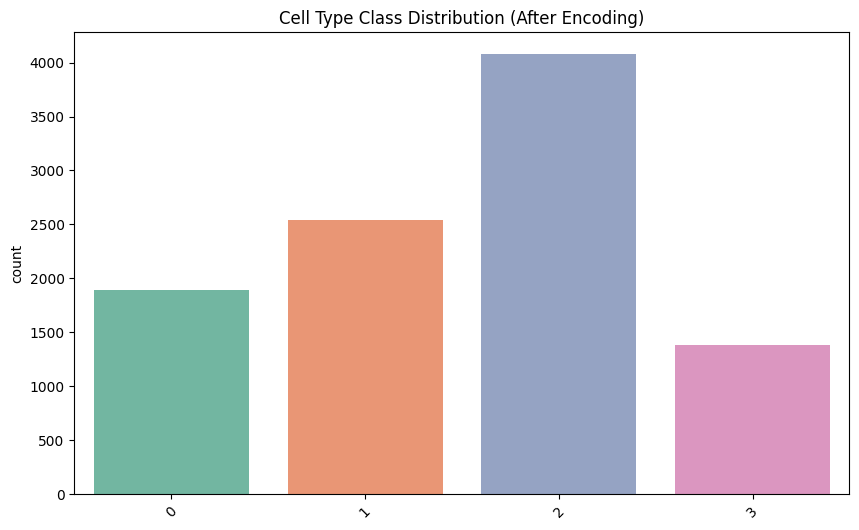

C:\Users\Munim\AppData\Local\Temp\ipykernel_20700\216892353.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_isCancerous, palette=colors, order=[0, 1])


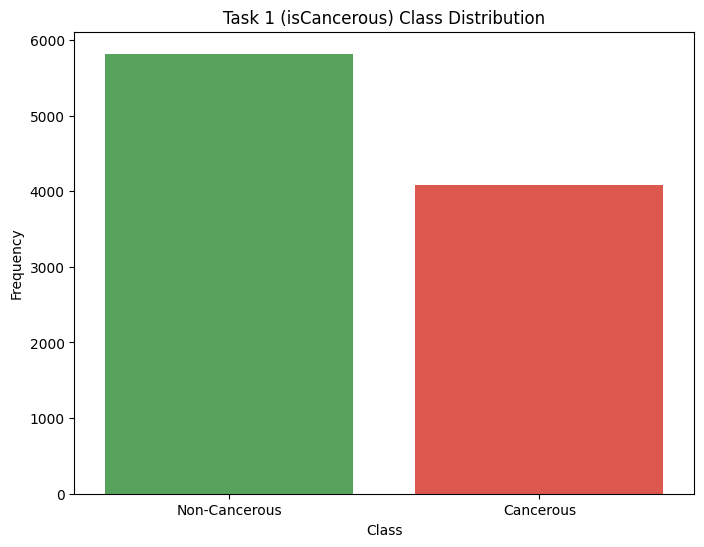

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert one-hot encoded back to integer for visualization
y_cellType_int = np.argmax(y_cellType_encoded, axis=1)

# Plot the distribution

# Define a color palette with as many colors as unique cell types
colors = sns.color_palette("Set2", len(cell_type_classes))

plt.figure(figsize=(10, 6))
sns.countplot(x=y_cellType_int, palette=colors, order=range(len(cell_type_classes)))
plt.title("Cell Type Class Distribution (After Encoding)")
plt.xticks(ticks=range(len(cell_type_classes)), labels=cell_type_classes, rotation=45)
plt.show()


# Plot distribution for isCancerous

colors = ['#4CAF50', '#F44336'] # Green for Non-Cancerous, Red for Cancerous
plt.figure(figsize=(8, 6))
sns.countplot(x=y_isCancerous, palette=colors, order=[0, 1])
plt.title("Task 1 (isCancerous) Class Distribution")
plt.xticks(ticks=[0, 1], labels=["Non-Cancerous", "Cancerous"])
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()



In [22]:
# Save data for label mappings for later use
# Save the label mappings for reference
cell_type_mapping = dict(zip(le.classes_, range(len(le.classes_))))
print("Cell Type Mapping:", cell_type_mapping)

# Final check on data shapes
print(f"Final X_task1 shape: {X_task1.shape}")
print(f"Final y_isCancerous shape: {y_isCancerous.shape}")
print(f"Final X_task2 shape: {X_task2.shape}")
print(f"Final y_cellType_encoded shape: {y_cellType_encoded.shape}")



Cell Type Mapping: {0: 0, 1: 1, 2: 2, 3: 3}
Final X_task1 shape: (9896, 27, 27, 3)
Final y_isCancerous shape: (9896,)
Final X_task2 shape: (9896, 27, 27, 3)
Final y_cellType_encoded shape: (9896, 4)


### Train validation test split

In [35]:
"""Since it is a patient-based dataset, splitting randomly may lead to data leakages,
to tacke this, we will split the data based on patient IDs
The training, validation, and testing sets has split ratios of 80%, 10%, and 10% respectively.

For the splitting stratified sampling is used to ensure that the distribution of the labels is similar in all sets.
The strafication is done based on patient IDs, so that all images from a single patient are in the same set.
"""



# Extract patient IDs from the dataset

import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

# Extract patient IDs for each task
patient_ids_task1 = [name.split('_')[0] for name in labels_task1['ImageName']]
patient_ids_task2 = [name.split('_')[0] for name in labels_task2['ImageName']]

# Get unique patient IDs
unique_patients_task1 = np.unique(patient_ids_task1)
unique_patients_task2 = np.unique(patient_ids_task2)

print(f"Unique patients in Task 1: {len(unique_patients_task1)}")
print(f"Unique patients in Task 2: {len(unique_patients_task2)}")




# Split the unique patient IDs into training and testing sets

# Task 1 (isCancerous) - Split patients
train_patients_task1, test_patients_task1 = train_test_split(unique_patients_task1, test_size=0.2, random_state=42)
train_patients_task1, val_patients_task1 = train_test_split(train_patients_task1, test_size=0.2, random_state=42)

# Task 2 (cellType) - Split patients
train_patients_task2, test_patients_task2 = train_test_split(unique_patients_task2, test_size=0.2, random_state=42)
train_patients_task2, val_patients_task2 = train_test_split(train_patients_task2, test_size=0.2, random_state=42)



# Group images by patient IDs

# Task 1 (isCancerous)
X_train_task1, y_train_task1 = [], []
X_val_task1, y_val_task1 = [], []
X_test_task1, y_test_task1 = [], []

for i, img in enumerate(X_task1):
    patient_id = labels_task1.iloc[i]['ImageName'].split('_')[0]
    
    if patient_id in train_patients_task1:
        X_train_task1.append(img)
        y_train_task1.append(y_isCancerous[i])
    elif patient_id in val_patients_task1:
        X_val_task1.append(img)
        y_val_task1.append(y_isCancerous[i])
    elif patient_id in test_patients_task1:
        X_test_task1.append(img)
        y_test_task1.append(y_isCancerous[i])

# Task 2 (cellType)
X_train_task2, y_train_task2 = [], []
X_val_task2, y_val_task2 = [], []
X_test_task2, y_test_task2 = [], []

for i, img in enumerate(X_task2):
    patient_id = labels_task2.iloc[i]['ImageName'].split('_')[0]
    
    if patient_id in train_patients_task2:
        X_train_task2.append(img)
        y_train_task2.append(y_cellType_encoded[i])
    elif patient_id in val_patients_task2:
        X_val_task2.append(img)
        y_val_task2.append(y_cellType_encoded[i])
    elif patient_id in test_patients_task2:
        X_test_task2.append(img)
        y_test_task2.append(y_cellType_encoded[i])

# Convert to numpy arrays
X_train_task1 = np.array(X_train_task1)
X_val_task1 = np.array(X_val_task1)
X_test_task1 = np.array(X_test_task1)
y_train_task1 = np.array(y_train_task1)
y_val_task1 = np.array(y_val_task1)
y_test_task1 = np.array(y_test_task1)

X_train_task2 = np.array(X_train_task2)
X_val_task2 = np.array(X_val_task2)
X_test_task2 = np.array(X_test_task2)
y_train_task2 = np.array(y_train_task2)
y_val_task2 = np.array(y_val_task2)
y_test_task2 = np.array(y_test_task2)

# Print the final shapes
print(f"Task 1 - Train: {X_train_task1.shape}, Val: {X_val_task1.shape}, Test: {X_test_task1.shape}")
print(f"Task 2 - Train: {X_train_task2.shape}, Val: {X_val_task2.shape}, Test: {X_test_task2.shape}")



Unique patients in Task 1: 20280
Unique patients in Task 2: 9896
Task 1 - Train: (6372, 27, 27, 3), Val: (1586, 27, 27, 3), Test: (1938, 27, 27, 3)
Task 2 - Train: (6332, 27, 27, 3), Val: (1584, 27, 27, 3), Test: (1980, 27, 27, 3)


## Task-1

### Building Baseline Models

#### Baseline Model 1: CNN

In [37]:
# Binary Classification Model for Task 1 (isCancerous)

"""Input shape: 27x27x3 (for RGB images)
Output shape: 1 (binary classification)"""

#Model Architecture

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers  # for layers like Conv2D, Dense, etc.
from tensorflow.keras import optimizers  # if using custom optimizers like SGD
from tensorflow.keras import regularizers  # for L2 regularization
from tensorflow.keras import callbacks  # for EarlyStopping, ModelCheckpoint, etc.
from tensorflow.keras import preprocessing  # for image preprocessing functions

from tensorflow.keras.layers import Activation



baseline_cnn_task1 = Sequential()

# One convolutional block only
baseline_cnn_task1.add(Conv2D(32, (3, 3), input_shape=(27, 27, 3)))
baseline_cnn_task1.add(Activation('sigmoid'))
baseline_cnn_task1.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten and Dense
baseline_cnn_task1.add(Flatten())
baseline_cnn_task1.add(Dense(1))
baseline_cnn_task1.add(Activation('sigmoid'))

optimizer = Adam(learning_rate=0.001)  # You can adjust the learning rate as needed

# Compile
baseline_cnn_task1.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])


# Model summary
baseline_cnn_task1.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 25, 25, 32)        896       
                                                                 
 activation (Activation)     (None, 25, 25, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 1)                 4609      
                                                                 
 activation_1 (Activation)   (None, 1)                 0         
                                                        

In [38]:
#Train the Model
# Training
history_task1 = baseline_cnn_task1.fit(X_train_task1, y_train_task1,
                              epochs=30,
                              batch_size=32,
                              validation_split=0.2)  # 20% of train set used for validation



Epoch 1/30
160/160 [==============================] - 9s 10ms/step - loss: 0.6553 - accuracy: 0.6325 - val_loss: 0.6463 - val_accuracy: 0.6039
Epoch 2/30
160/160 [==============================] - 1s 6ms/step - loss: 0.5661 - accuracy: 0.7083 - val_loss: 0.6999 - val_accuracy: 0.5239
Epoch 3/30
160/160 [==============================] - 1s 6ms/step - loss: 0.5202 - accuracy: 0.7379 - val_loss: 0.7780 - val_accuracy: 0.5098
Epoch 4/30
160/160 [==============================] - 1s 6ms/step - loss: 0.4903 - accuracy: 0.7599 - val_loss: 0.6365 - val_accuracy: 0.6071
Epoch 5/30
160/160 [==============================] - 1s 5ms/step - loss: 0.4730 - accuracy: 0.7667 - val_loss: 0.5340 - val_accuracy: 0.7247
Epoch 6/30
160/160 [==============================] - 1s 6ms/step - loss: 0.4305 - accuracy: 0.8038 - val_loss: 0.4863 - val_accuracy: 0.7671
Epoch 7/30
160/160 [==============================] - 1s 6ms/step - loss: 0.4182 - accuracy: 0.8117 - val_loss: 0.4248 - val_accuracy: 0.8220
Epoch

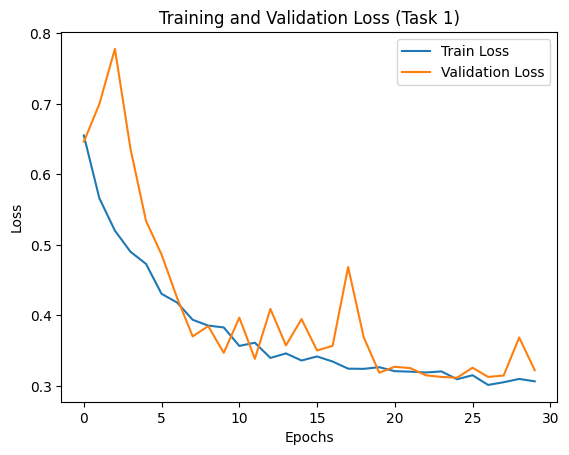

In [39]:
import matplotlib.pyplot as plt

# # Accuracy Plot
# plt.plot(history_task1.history['accuracy'], label='Train Accuracy')
# plt.plot(history_task1.history['val_accuracy'], label='Validation Accuracy')
# plt.title('Training and Validation Accuracy (Task 1)')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

# Loss Plot
plt.plot(history_task1.history['loss'], label='Train Loss')
plt.plot(history_task1.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (Task 1)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [40]:
# Evaluate on Validation Set
test_loss, test_accuracy = baseline_cnn_task1.evaluate(X_val_task1, y_val_task1)
print(f"Test Accuracy (Task 1 - isCancerous): {test_accuracy:.4f}")


# Final Evaluation
# test_loss, test_accuracy = baseline_cnn_task1.evaluate(X_test_task1, y_test_task1)
# print(f"Test Accuracy (Task 1 - isCancerous): {test_accuracy:.4f}")


50/50 [==============================] - 0s 7ms/step - loss: 0.2921 - accuracy: 0.8865
Test Accuracy (Task 1 - isCancerous): 0.8865


In [64]:
# from sklearn.metrics import confusion_matrix, classification_report

# # Predict
# y_pred_task1 = (baseline_cnn_task1.predict(X_test_task1) > 0.5).astype("int32")

# # Confusion matrix
# cm = confusion_matrix(y_test_task1, y_pred_task1)
# print("Confusion Matrix:\n", cm)

# # Classification report
# print(classification_report(y_test_task1, y_pred_task1))


## Improving CNN Model from Baseline Task-1(Binary Classification)

In [41]:
# Improved Binary Classification Model for Task 1 (isCancerous)

"""Input shape: 27x27x3 (for RGB images)
Output shape: 1 (binary classification)"""

#Model Architecture

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers  # for layers like Conv2D, Dense, etc.
from tensorflow.keras import optimizers  # if using custom optimizers like SGD
from tensorflow.keras import regularizers  # for L2 regularization
from tensorflow.keras import callbacks  # for EarlyStopping, ModelCheckpoint, etc.
from tensorflow.keras import preprocessing  # for image preprocessing functions

from tensorflow.keras.layers import Activation

from tensorflow.keras.optimizers import RMSprop



#Convulutional block 1

improved_cnn_task1 = Sequential()
improved_cnn_task1.add(Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(0.001), input_shape=(27,27,3)))
improved_cnn_task1.add(Activation('relu'))
improved_cnn_task1.add(MaxPooling2D(pool_size=(2, 2)))



#Convulutional block 2
improved_cnn_task1.add(Conv2D(64, (3, 3)))
improved_cnn_task1.add(Activation('relu'))
improved_cnn_task1.add(MaxPooling2D(pool_size=(2, 2)))

#Convulutional block 3

improved_cnn_task1.add(Conv2D(128, (3, 3)))
improved_cnn_task1.add(Activation('relu'))
# Optional: pooling after third conv
# improved_cnn_task1.add(MaxPooling2D(pool_size=(2, 2)))

# #Convulutional block 4
# improved_cnn_task1.add(Conv2D(256, (3, 3)))
# improved_cnn_task1.add(Activation('relu'))



#start multiple layers

improved_cnn_task1.add(Flatten()) # Flatten the 3d tensor to 1d
improved_cnn_task1.add(Dense(64))
improved_cnn_task1.add(Activation('relu'))
improved_cnn_task1.add(Dropout(0.5))  # Dropout layer to reduce overfitting
improved_cnn_task1.add(Dense(1))  # Output layer for binary classification
improved_cnn_task1.add(Activation('sigmoid'))  # Sigmoid activation for binary classification

# sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

# improved_cnn_task1.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

# Model summary
improved_cnn_task1.summary()


# optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, amsgrad=False)


optimizer = Adam(learning_rate=0.0001)

# optimizer = RMSprop(learning_rate=0.0005)

# optimizer = RMSprop(learning_rate=0.0001, decay=1e-6, momentum=0.9)


improved_cnn_task1.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# improved_cnn_task1.compile(loss='binary_crossentropy',
#                            optimizer='sgd',
#                            metrics=['accuracy'])



## Some comments 
""" Reducing one maxpooling layer increased the accuracy of the model.
    RMSprop optimizer with learning rate of 0.0005 is not giving good results however the accuracy was good but with lots of spike in the loss graph.
    Adam optimizer with learning rate of 0.0001 is giving good results."""



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 25, 25, 32)        896       
                                                                 
 activation_2 (Activation)   (None, 25, 25, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 64)        18496     
                                                                 
 activation_3 (Activation)   (None, 10, 10, 64)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                  

' Reducing one maxpooling layer increased the accuracy of the model.\n    RMSprop optimizer with learning rate of 0.0005 is not giving good results however the accuracy was good but with lots of spike in the loss graph.\n    Adam optimizer with learning rate of 0.0001 is giving good results.'

In [66]:
# Improving CNN Model from Baseline 


"""Data augmentating did not improve the accuracy of the model."""

# Image data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Normalize + augment
augment_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Validation data — only rescaling
val_gen = ImageDataGenerator(rescale=1./255)

# Create generators from array data
train_generator = augment_gen.flow(X_train_task1, y_train_task1, batch_size=32)
val_generator = val_gen.flow(X_test_task1, y_test_task1, batch_size=32)






Epoch 1/20
200/200 [==============================] - ETA: 0s - loss: 0.5899 - accuracy: 0.6798
Epoch 1: val_loss improved from inf to 0.42948, saving model to best_model_task1.h5
200/200 [==============================] - 3s 10ms/step - loss: 0.5899 - accuracy: 0.6798 - val_loss: 0.4295 - val_accuracy: 0.8426
Epoch 2/20
194/200 [============================>.] - ETA: 0s - loss: 0.3845 - accuracy: 0.8413
Epoch 2: val_loss improved from 0.42948 to 0.32330, saving model to best_model_task1.h5
200/200 [==============================] - 2s 8ms/step - loss: 0.3843 - accuracy: 0.8412 - val_loss: 0.3233 - val_accuracy: 0.8798
Epoch 3/20
197/200 [============================>.] - ETA: 0s - loss: 0.3345 - accuracy: 0.8677
Epoch 3: val_loss improved from 0.32330 to 0.30272, saving model to best_model_task1.h5
200/200 [==============================] - 2s 8ms/step - loss: 0.3355 - accuracy: 0.8672 - val_loss: 0.3027 - val_accuracy: 0.8782
Epoch 4/20
192/200 [===========================>..] - ETA:

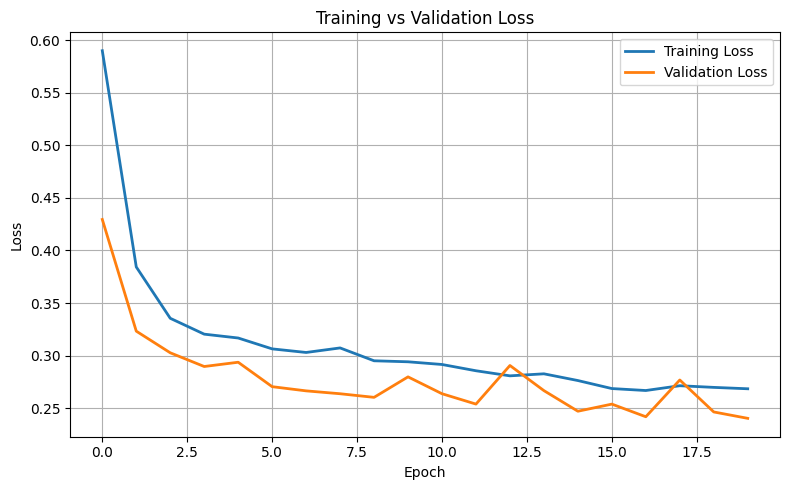

In [42]:
# history = improved_cnn_task1.fit(
#     train_generator,
#     epochs=20,
#     validation_data=val_generator,
#     steps_per_epoch=len(X_train_task1) // 32,
#     validation_steps=len(X_test_task1) // 32,
#     #callbacks=[early_stop, model_checkpoint]  # Optional: add EarlyStopping, etc.
# )


# Without augmentation

# early stopping and model checkpointing

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=4,  # number of epochs to wait before stopping
    restore_best_weights=True,
    verbose=1
)

# Model checkpoint to save the best model based on val_loss
model_checkpoint = ModelCheckpoint(
    filepath='best_model_task1.h5',  # you can name this whatever you like
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)





history = improved_cnn_task1.fit(
    X_train_task1,
    y_train_task1,
    epochs=20,
    batch_size=32,
    validation_data=(X_test_task1, y_test_task1),
    callbacks=[early_stop, model_checkpoint]  # Add reduce_lr or live_plot if needed
)







import matplotlib.pyplot as plt

# Example history object assumed to be named `history`
# This function will work only if `history` is defined and contains `loss` and `val_loss`

def plot_loss(history):
    plt.figure(figsize=(8,5))
    plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Attempt to plot assuming history variable is available in user's environment
try:
    plot_loss(history)
except Exception as e:
    str(e)



# # Evaluate
# test_loss, test_accuracy = improved_cnn_task1.evaluate(X_test_task1, y_test_task1)
# print(f"Test Accuracy (Task 1 - isCancerous): {test_accuracy:.4f}")






In [ ]:
# Final Evaluation
test_loss, test_accuracy = improved_cnn_task1.evaluate(X_val_task1, y_val_task1)
print(f"Test Accuracy (Task 1 - isCancerous): {test_accuracy:.4f}")

# Final Evaluation
# test_loss, test_accuracy = improved_cnn_task1.evaluate(X_test_task1, y_test_task1)
# print(f"Test Accuracy (Task 1 - isCancerous): {test_accuracy:.4f}")

50/50 [==============================] - 0s 6ms/step - loss: 0.2522 - accuracy: 0.9048
Test Accuracy (Task 1 - isCancerous): 0.9048


## Task 2

### Baseline Model

In [69]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam

model_task2 = Sequential()

# Conv Block 1
model_task2.add(Conv2D(32, (3, 3), input_shape=(27, 27, 3)))
model_task2.add(Activation('sigmoid'))
model_task2.add(MaxPooling2D(pool_size=(2, 2)))

# Conv Block 2
# model_task2.add(Conv2D(64, (3, 3)))
# model_task2.add(Activation('relu'))
# Optional: skip pooling if accuracy drops

# Flatten and Dense
model_task2.add(Flatten())
model_task2.add(Dense(64))
model_task2.add(Activation('sigmoid'))
model_task2.add(Dropout(0.5))
model_task2.add(Dense(4))  # 4 classes
model_task2.add(Activation('softmax'))  # for multiclass

optimizer = Adam(learning_rate=0.0001)

# Compile
model_task2.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model_task2.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 25, 25, 32)        896       
                                                                 
 activation_32 (Activation)  (None, 25, 25, 32)        0         
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 12, 12, 32)       0         
 g2D)                                                            
                                                                 
 flatten_8 (Flatten)         (None, 4608)              0         
                                                                 
 dense_14 (Dense)            (None, 64)                294976    
                                                                 
 activation_33 (Activation)  (None, 64)                0         
                                                      

Epoch 1/30
198/198 [==============================] - 3s 12ms/step - loss: 1.3506 - accuracy: 0.3866 - val_loss: 1.2963 - val_accuracy: 0.4211
Epoch 2/30
198/198 [==============================] - 2s 9ms/step - loss: 1.3174 - accuracy: 0.4138 - val_loss: 1.3004 - val_accuracy: 0.4211
Epoch 3/30
198/198 [==============================] - 2s 9ms/step - loss: 1.3135 - accuracy: 0.4139 - val_loss: 1.2922 - val_accuracy: 0.4211
Epoch 4/30
198/198 [==============================] - 1s 7ms/step - loss: 1.3093 - accuracy: 0.4135 - val_loss: 1.2912 - val_accuracy: 0.4211
Epoch 5/30
198/198 [==============================] - 2s 10ms/step - loss: 1.3084 - accuracy: 0.4133 - val_loss: 1.2873 - val_accuracy: 0.4211
Epoch 6/30
198/198 [==============================] - 2s 9ms/step - loss: 1.3072 - accuracy: 0.4139 - val_loss: 1.2843 - val_accuracy: 0.4211
Epoch 7/30
198/198 [==============================] - 2s 8ms/step - loss: 1.2960 - accuracy: 0.4133 - val_loss: 1.2752 - val_accuracy: 0.4211
Epoc

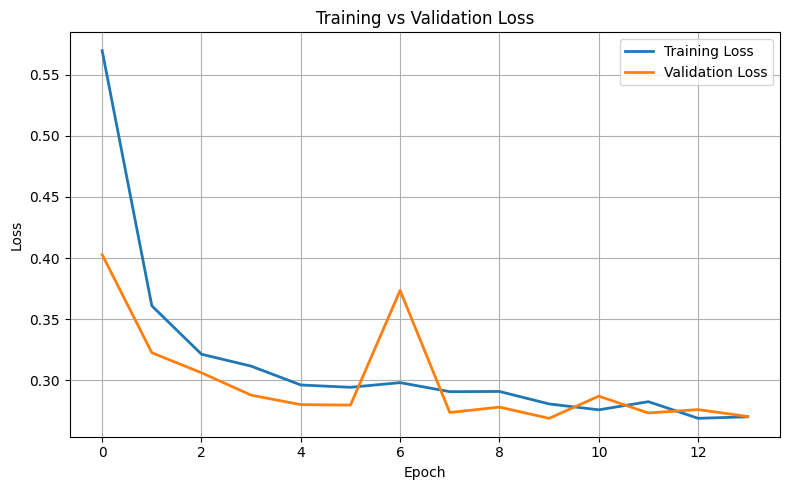

In [70]:
#Train the Model
# Training
history2 = model_task2.fit(X_train_task2, y_train_task2,
                              epochs=30,
                              batch_size=32,
                              validation_split=0.2)  # 20% of train set used for validation



import matplotlib.pyplot as plt

# Example history object assumed to be named `history`
# This function will work only if `history` is defined and contains `loss` and `val_loss`

def plot_loss(history2):
    plt.figure(figsize=(8,5))
    plt.plot(history2.history['loss'], label='Training Loss', linewidth=2)
    plt.plot(history2.history['val_loss'], label='Validation Loss', linewidth=2)
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Attempt to plot assuming history variable is available in user's environment
try:
    plot_loss(history)
except Exception as e:
    str(e)





In [71]:
# Evaluate
test_loss, test_accuracy = model_task2.evaluate(X_test_task2, y_test_task2)
print(f"Test Accuracy (Task 2 - Cell Type): {test_accuracy:.4f}")

62/62 [==============================] - 0s 5ms/step - loss: 0.9891 - accuracy: 0.6379
Test Accuracy (Task 2 - Cell Type): 0.6379


### Devised Model for task 2

In [110]:
# Improved Binary Classification Model for Task 2 (cellType)

"""Input shape: 27x27x3 (for RGB images)
Output shape: 4 (classes for cell types)"""

#Model Architecture

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers  # for layers like Conv2D, Dense, etc.
from tensorflow.keras import optimizers  # if using custom optimizers like SGD
from tensorflow.keras import regularizers  # for L2 regularization
from tensorflow.keras import callbacks  # for EarlyStopping, ModelCheckpoint, etc.
from tensorflow.keras import preprocessing  # for image preprocessing functions

from tensorflow.keras.layers import Activation

from tensorflow.keras.optimizers import RMSprop



#Convulutional block 1

improved_cnn_task2 = Sequential()
improved_cnn_task2.add(Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(0.001), input_shape=(27,27,3)))
improved_cnn_task2.add(Activation('relu'))
improved_cnn_task2.add(MaxPooling2D(pool_size=(2, 2)))



#Convulutional block 2
improved_cnn_task2.add(Conv2D(64, (3, 3)))
improved_cnn_task2.add(Activation('relu'))
improved_cnn_task2.add(MaxPooling2D(pool_size=(2, 2)))

#Convulutional block 3

improved_cnn_task2.add(Conv2D(128, (3, 3)))
improved_cnn_task2.add(Activation('relu'))
# Optional: pooling after third conv
# improved_cnn_task2.add(MaxPooling2D(pool_size=(2, 2)))

#Convulutional block 4
improved_cnn_task2.add(Conv2D(256, (3, 3)))
improved_cnn_task2.add(Activation('relu'))

# Optional: pooling after fourth conv
# improved_cnn_task2.add(MaxPooling2D(pool_size=(2, 2)))



#start multiple layers

improved_cnn_task2.add(Flatten()) # Flatten the 3d tensor to 1d
improved_cnn_task2.add(Dense(64))
improved_cnn_task2.add(Activation('relu'))
improved_cnn_task2.add(Dropout(0.5))  # Dropout layer to reduce overfitting
improved_cnn_task2.add(Dense(4))  # Output layer for binary classification
improved_cnn_task2.add(Activation('softmax'))  # Softmax activation for multiclass classification

# sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

# improved_cnn_task2.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

# Model summary
improved_cnn_task2.summary()


# optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, amsgrad=False)


optimizer = Adam(learning_rate=0.0001)

# optimizer = RMSprop(learning_rate=0.0005)

# optimizer = RMSprop(learning_rate=0.0001, decay=1e-6, momentum=0.9)


improved_cnn_task2.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# improved_cnn_task2.compile(loss='binary_crossentropy',
#                            optimizer='sgd',
#                            metrics=['accuracy'])



## Some comments 
"""   """











# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras import regularizers

# # Create improved CNN
# improved_cnn_task2 = Sequential()

# # 🔹 Block 1
# improved_cnn_task2.add(Conv2D(16, (3, 3), padding='same', input_shape=(27, 27, 3),
#                               kernel_regularizer=regularizers.l2(0.001)))
# improved_cnn_task2.add(BatchNormalization())
# improved_cnn_task2.add(Activation('relu'))
# improved_cnn_task2.add(MaxPooling2D(pool_size=(2, 2)))

# # 🔹 Block 2
# improved_cnn_task2.add(Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.001)))
# improved_cnn_task2.add(BatchNormalization())
# improved_cnn_task2.add(Activation('relu'))
# improved_cnn_task2.add(MaxPooling2D(pool_size=(2, 2)))

# # 🔹 Block 3
# improved_cnn_task2.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.001)))
# improved_cnn_task2.add(BatchNormalization())
# improved_cnn_task2.add(Activation('relu'))

# # 🔹 Classifier head
# improved_cnn_task2.add(Flatten())
# improved_cnn_task2.add(Dense(128, kernel_regularizer=regularizers.l2(0.001)))
# improved_cnn_task2.add(BatchNormalization())
# improved_cnn_task2.add(Activation('relu'))
# improved_cnn_task2.add(Dropout(0.5))  # helps reduce overfitting

# # 🔹 Output layer
# improved_cnn_task2.add(Dense(4, activation='softmax'))  # 4-class classification

# # Compile
# optimizer = Adam(learning_rate=0.0001)

# # sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

# # optimizer = RMSprop(learning_rate=0.0005)
# improved_cnn_task2.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# # Model summary
# improved_cnn_task2.summary()


Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_76 (Conv2D)          (None, 25, 25, 32)        896       
                                                                 
 activation_103 (Activation)  (None, 25, 25, 32)       0         
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 12, 12, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_77 (Conv2D)          (None, 10, 10, 64)        18496     
                                                                 
 activation_104 (Activation)  (None, 10, 10, 64)       0         
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 5, 5, 64)         0         
 g2D)                                                

'   '

In [ ]:
# from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, Flatten, Dense, Dropout
# from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras import regularizers

# def resnet_block(x, filters, kernel_size=3):
#     shortcut = x

#     # First conv
#     x = Conv2D(filters, kernel_size, padding='same', kernel_regularizer=regularizers.l2(0.001))(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)

#     # Second conv
#     x = Conv2D(filters, kernel_size, padding='same', kernel_regularizer=regularizers.l2(0.001))(x)
#     x = BatchNormalization()(x)

#     # 🔧 Projection shortcut (only if needed)
#     if shortcut.shape[-1] != filters:
#         shortcut = Conv2D(filters, (1, 1), padding='same', kernel_regularizer=regularizers.l2(0.001))(shortcut)
#         shortcut = BatchNormalization()(shortcut)

#     # Add skip connection
#     x = Add()([x, shortcut])
#     x = Activation('relu')(x)
#     return x

# # Input layer
# input_layer = Input(shape=(27, 27, 3))

# # Initial conv
# x = Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.001))(input_layer)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)

# x = MaxPooling2D(pool_size=(2, 2))(x)

# # Residual block 1
# x = resnet_block(x, 32)
# x = MaxPooling2D(pool_size=(2, 2))(x)

# # Residual block 2
# x = resnet_block(x, 64)

# # Flatten and dense head
# x = Flatten()(x)
# x = Dense(128, kernel_regularizer=regularizers.l2(0.001))(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)
# x = Dropout(0.5)(x)

# # Output layer: 4 cell types
# output_layer = Dense(4, activation='softmax')(x)

# # Model
# resnet_model = Model(inputs=input_layer, outputs=output_layer)

# # Compile
# optimizer = Adam(learning_rate=0.0001)
# resnet_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# # Summary
# resnet_model.summary()



Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 27, 27, 3)]  0           []                               
                                                                                                  
 conv2d_67 (Conv2D)             (None, 27, 27, 32)   896         ['input_4[0][0]']                
                                                                                                  
 batch_normalization_31 (BatchN  (None, 27, 27, 32)  128         ['conv2d_67[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_93 (Activation)     (None, 27, 27, 32)   0           ['batch_normalization_31[0]

Epoch 1/100
247/247 [==============================] - ETA: 0s - loss: 1.3335 - accuracy: 0.4122
Epoch 1: val_loss improved from inf to 1.32078, saving model to best_model_task1.h5
247/247 [==============================] - 8s 28ms/step - loss: 1.3335 - accuracy: 0.4122 - val_loss: 1.3208 - val_accuracy: 0.4032
Epoch 2/100
245/247 [============================>.] - ETA: 0s - loss: 1.3185 - accuracy: 0.4129
Epoch 2: val_loss improved from 1.32078 to 1.31978, saving model to best_model_task1.h5
247/247 [==============================] - 6s 25ms/step - loss: 1.3187 - accuracy: 0.4122 - val_loss: 1.3198 - val_accuracy: 0.3991
Epoch 3/100
247/247 [==============================] - ETA: 0s - loss: 1.3161 - accuracy: 0.4141
Epoch 3: val_loss improved from 1.31978 to 1.31906, saving model to best_model_task1.h5
247/247 [==============================] - 6s 26ms/step - loss: 1.3161 - accuracy: 0.4141 - val_loss: 1.3191 - val_accuracy: 0.4011
Epoch 4/100
246/247 [============================>.] 

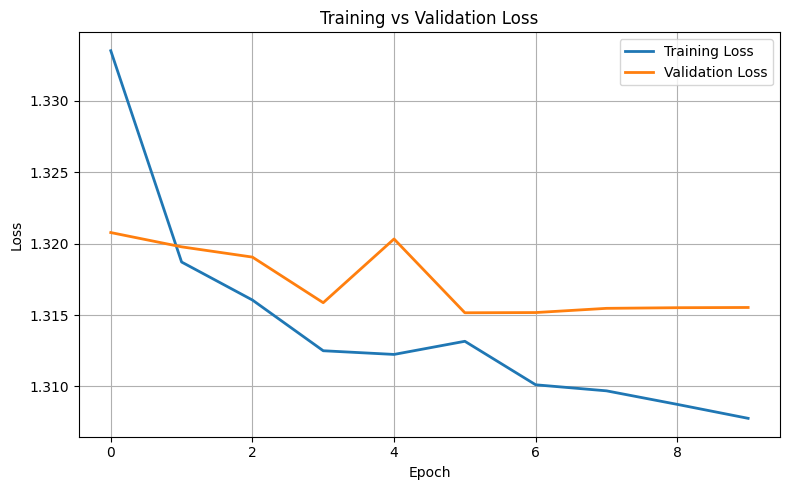

In [ ]:
# history = improved_cnn_task1.fit(
#     train_generator,
#     epochs=20,
#     validation_data=val_generator,
#     steps_per_epoch=len(X_train_task1) // 32,
#     validation_steps=len(X_test_task1) // 32,
#     #callbacks=[early_stop, model_checkpoint]  # Optional: add EarlyStopping, etc.
# )


# Without augmentation

# early stopping and model checkpointing

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=4,  # number of epochs to wait before stopping
    restore_best_weights=True,
    verbose=1
)

# Model checkpoint to save the best model based on val_loss
model_checkpoint = ModelCheckpoint(
    filepath='best_model_task1.h5',  # you can name this whatever you like
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)





# history = resnet_model.fit(
#     X_train_task2,
#     y_train_task2,
#     epochs=100,
#     batch_size=32,
#     validation_data=(X_test_task2, y_test_task2),
#     callbacks=[early_stop, model_checkpoint]  # Add reduce_lr or live_plot if needed
# )


# with Augmentation

# Image data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Normalize + augment
augment_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Validation data — only rescaling
val_gen = ImageDataGenerator(rescale=1./255)

# Create generators from array data
train_generator = augment_gen.flow(X_train_task2, y_train_task2, batch_size=32)
val_generator = val_gen.flow(X_test_task2, y_test_task2, batch_size=32)




history = improved_cnn_task2.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    steps_per_epoch=len(X_train_task2) // 32,
    validation_steps=len(X_test_task2) // 32,
    callbacks=[early_stop, model_checkpoint]  # Optional: add EarlyStopping, etc.
)







import matplotlib.pyplot as plt

# Example history object assumed to be named `history`
# This function will work only if `history` is defined and contains `loss` and `val_loss`

def plot_loss(history):
    plt.figure(figsize=(8,5))
    plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Attempt to plot assuming history variable is available in user's environment
try:
    plot_loss(history)
except Exception as e:
    str(e)



# # Evaluate
# test_loss, test_accuracy = improved_cnn_task1.evaluate(X_test_task1, y_test_task1)
# print(f"Test Accuracy (Task 1 - isCancerous): {test_accuracy:.4f}")






In [107]:
# Evaluate
test_loss, test_accuracy = improved_cnn_task2.evaluate(X_test_task2, y_test_task2)
print(f"Test Accuracy (Task 2 - Cell Type): {test_accuracy:.4f}")

62/62 [==============================] - 0s 7ms/step - loss: 1.1328 - accuracy: 0.6192
Test Accuracy (Task 2 - Cell Type): 0.6192
